<a href="https://colab.research.google.com/github/slowvak/MC4-TensorflowUNet/blob/master/Basic_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1 loads up all the libraries we are using. In the first lessons, we used fastAI, while in this one we use Tensorflow with Keras. Both of these are large libraries, and its designers decided to allow programmers to load only the pieces that are relevant, which is what the 'from keras.XXX import YYY' lines do--they load just the partrt of Keras (or other library) that we want. This makes the load time faster and the final running program smaller.

The second half of this cell does the familiar step of loading the data sets that I have prepared, which in this case are a series of abdominal CTs as well as hand-traced masks of the Pancreas, courtesy of The Cancer Image Archive: http://TheCancerImageArchive....

In [1]:
#Cell 1
# Load the {{PROCESSED}} images and the masks for pancreas from RSNA repository
# To make load times reasonable, only slices with pancreas are included
#  and these are 8 bit JPEG images (compresssed)

!rm -rf ./MC4-TensorflowUNet

!rm -rf images
!mkdir images
!rm -rf masks
!mkdir masks


import os

!git clone https://github.com/slowvak/MC4-TensorflowUNet.git


#for f in os.listdir('./MC4-TensorflowUNet'):
#    cmd = 'unzip ./MC4-TensorflowUNet/{}'.format(f)
#    os.system(cmd)
#    limit = limit - 1
#    if limit < 0:
#        break

!unzip ./MC4-TensorflowUNet/Pt1.zip
!unzip ./MC4-TensorflowUNet/Pt2.zip
!unzip ./MC4-TensorflowUNet/Pt3.zip

!mv *-Mask.jpg ./masks
!mv *.jpg ./images

#!ls images


Cloning into 'MC4-TensorflowUNet'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 100 (delta 3), reused 0 (delta 0), pack-reused 85
Receiving objects: 100% (100/100), 371.26 MiB | 27.68 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Checking out files: 100% (92/92), done.
Archive:  ./MC4-TensorflowUNet/Pt1.zip
  inflating: 01-00000-Mask.jpg       
  inflating: 01-00000.jpg            
  inflating: 01-00001-Mask.jpg       
  inflating: 01-00001.jpg            
  inflating: 01-00002-Mask.jpg       
  inflating: 01-00002.jpg            
  inflating: 01-00003-Mask.jpg       
  inflating: 01-00003.jpg            
  inflating: 01-00004-Mask.jpg       
  inflating: 01-00004.jpg            
  inflating: 01-00005-Mask.jpg       
  inflating: 01-00005.jpg            
  inflating: 01-00006-Mask.jpg       
  inflating: 01-00006.jpg            
  inflating: 01-00007-Mask.jpg       
  inflating: 

In [2]:
!pip install -q keras
import keras
from __future__ import print_function
import cv2
import numpy as np

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from keras.layers.merge import concatenate, add
from keras.layers.core import Lambda
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
import numpy
import matplotlib as plt
#import matplotlib.image as mpimg
import imageio



Using TensorFlow backend.


In [3]:
# Get training and testing data
# This Block loads the training images and training masks into numpy arrays of shape (n, 256, 256)


train_X = []
train_Y = []
test_X = []
test_Y = []


limit = 3500  # limit number of subjects due to memory limits
test_num = 250  # will also load some test images for the end

im_list = os.listdir('./images')

for f in im_list:
  pth = './images/' + f 
  img = imageio.imread(pth)
  if len(train_X) >= limit:
    test_X.append(np.array(img))
  else:
    train_X.append(np.array(img))
  if len(test_X) >= test_num:
    break

im_list = os.listdir('./masks')
for f in im_list:
  pth = './masks/' + f 
  img = imageio.imread(pth)
  if len(train_Y) >= limit:
    test_Y.append(np.array(img))
  else:
    train_Y.append(np.array(img))
  if len(test_Y) >= test_num:
    break

X_array = numpy.array(train_X)
Y_array = numpy.array(train_Y)  
# the 2 lines below adds an axis, which is needed by Keras
X_array = X_array[..., np.newaxis]
Y_array = Y_array[..., np.newaxis]

X_test = numpy.array(test_X)
Y_test = numpy.array(test_Y)                                            
X_test = X_test[..., np.newaxis]
Y_test = Y_test[..., np.newaxis]

X_array.shape
CHANNELS = X_array.shape[3]
IMG_WIDTH = X_array.shape[2]
IMG_HEIGHT = X_array.shape[1]
NUM_IMAGES = X_array.shape[0]
K.set_image_dim_ordering('tf')

print (str(NUM_IMAGES) + ' for training and validation, and testing has ' + str(X_test.shape[0]))


3500 for training and validation, and testing has 250


# Cost Functions
A critical element of every machine learning algorithm is to select a good cost function. In the classificaiton problems of prior articles, we used the accuracy of predictions as the cost function. For segmentation, one potentially could compute a score for teh classification of each pixel (object or not object), but a more common metric is the Dice Similiarity Score (a.k.a. Dice Score). This essentially means the amount of overlap between the gold standard and the prediction. If they perfectly agree, the Dice Score is 1, and if there is no overlap, the score is 0. We can convert the Dice Score toa Dice Loss by subtracting it from 1. One can also convert the Dice Score to a cross-entropy function, and this can work well in some cases. Code for both is provided, and you are encouraged to try both cost functions to see the effect.
Note, however, that the above can result in Dice values of zero, and we don't want to divide by zero. In fact, we don't want to divide by a small number, so we add 'smooth' to the value (in our case we are using 1) so the values of Dice actually are 1 to 2, not 0 to 1. And that means the Dice Loss will be -1 to 0, but the loss reported is the sum, so it will have a larger range.

In [0]:
# Cell 
tf.reset_default_graph()

def dice_coeff(y_true, y_pred):
    smooth = 0.000001
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

#binary cross entropy is another function that can perform well
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

##Building the U-Net
We are finally ready to build our Network. One difference of Keras versus the previous examples of FastAI is that Keras is designed so that there is one line of code for each layer of the network (plus the setup and training/evlauation code).  This means that for a moderately complex network like a ResNet34 classifier, there would be 34 lines of code. 
U-Nets are popular network architectures for segmentation. These get their name because of the unique way they are built: The first part produces repeated reductions in resolution as the 'important' parts of the image are retained that reflect the structures that it is trained to recognize. Typically there are 4 or 5 such reduction layers that each consist of convultions, ReLUs, and Pooling layers. 
Once the image is reduced to the critical components, the networks begins to reconstruct the precise margins of the critical elements by using 'skip layers'. As the resolution is stored using convolutional-transpose layers, the layers 'look' back to the layers where the resolution was reduced to try to best define the margins of the structures.
See Ronneberger...

In [0]:
# Cell 


# Build U-Net model
def build_model(drop_out = 0.0, act_fn = 'relu', init_fn = 'he_normal'):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(32, (7, 7), activation=act_fn, kernel_initializer=init_fn, padding='same') (s)
    #c1 = Conv2D(32, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (s)
    if drop_out > 0.0:
        c1 = Dropout(drop_out) (c1)
        c1 = Conv2D(32, (7, 7), activation=act_fn, kernel_initializer=init_fn, padding='same') (c1)
    p1 = MaxPooling2D(pool_size=(2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (p1)
    if drop_out > 0.0:
        c2 = Dropout(drop_out) (c2)
        c2 = Conv2D(32, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (p2)
    if drop_out > 0.0:
        c3 = Dropout(drop_out) (c3)
        c3 = Conv2D(64, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (p3)
    if drop_out > 0.0:
        c4 = Dropout(drop_out) (c4)
        c4 = Conv2D(128, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (p4)
    if drop_out > 0.0:
        c5 = Dropout(drop_out) (c5)
        c5 = Conv2D(256, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (u6)
    if drop_out > 0.0:
        c6 = Dropout(drop_out) (c6)
        c6 = Conv2D(128, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (u7)
    if drop_out > 0.0:
        c7 = Dropout(drop_out) (c7)
        c7 = Conv2D(64, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (u8)
    if drop_out > 0.0:
        c8 = Dropout(drop_out) (c8)
        c8 = Conv2D(32, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (u9)
    if drop_out > 0.0:
        c9 = Dropout(drop_out) (c9)
        c9 = Conv2D(16, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #model.compile(optimizer='adam'(lr=0.0001,decay=0.000001), loss='dice_loss', metrics=[dice_coeff])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coeff])
#    model.summary()
    return model



# Build U-Net model
def build_shallow_model(drop_out = 0.0, act_fn = 'relu', init_fn = 'he_normal'):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(32, (7, 7), activation=act_fn, kernel_initializer=init_fn, padding='same') (s)
    #c1 = Conv2D(32, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (s)
    if drop_out > 0.0:
        c1 = Dropout(drop_out) (c1)
        c1 = Conv2D(32, (7, 7), activation=act_fn, kernel_initializer=init_fn, padding='same') (c1)
    p1 = MaxPooling2D(pool_size=(2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (p1)
    if drop_out > 0.0:
        c2 = Dropout(drop_out) (c2)
        c2 = Conv2D(32, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (p2)
    if drop_out > 0.0:
        c3 = Dropout(drop_out) (c3)
        c3 = Conv2D(64, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c3)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (u8)
    if drop_out > 0.0:
        c8 = Dropout(drop_out) (c8)
        c8 = Conv2D(32, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (u9)
    if drop_out > 0.0:
        c9 = Dropout(drop_out) (c9)
        c9 = Conv2D(16, (3, 3), activation=act_fn, kernel_initializer=init_fn, padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #model.compile(optimizer='adam'(lr=0.0001,decay=0.000001), loss='dice_loss', metrics=[dice_coeff])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coeff])
#    model.summary()
    return model


# Train it
Now that our model is built, we are (finally!) ready to train it. Trial and error with colab hardware (K80) has shown that a batch_size of 16 works, and that we can get reasonable results adfter 5 epochs (but you can train longer to get better results)

In [0]:

epochs = 100
batch_size = 64

# Fit model
checkpointer = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

#for dropout in [0.0, 0.2, 0.5]:
for dropout in [0.0]:
    print ('\n\nDropout = ' + str(dropout))
    model = build_shallow_model(drop_out = dropout)
    # adding dropout takes 2x time, so allow for twice as many epochs to get about equal execution time
    if dropout < 0.05:
        epoch_cnt = epochs * 2
    else:
        epoch_cnt = epochs
    results = model.fit(X_array, Y_array, validation_split=0.2, batch_size=batch_size, epochs=epoch_cnt, callbacks=[checkpointer])



Dropout = 0.0
Train on 2800 samples, validate on 700 samples
Epoch 1/200
2800/2800 [==============================] - 17s 6ms/step - loss: 0.5088 - dice_coeff: 0.5611 - val_loss: -0.1788 - val_dice_coeff: 0.8503

Epoch 00001: val_loss improved from inf to -0.17877, saving model to model.h5
Epoch 2/200
2800/2800 [==============================] - 16s 6ms/step - loss: 0.1989 - dice_coeff: 0.7415 - val_loss: -0.3296 - val_dice_coeff: 0.8592

Epoch 00002: val_loss improved from -0.17877 to -0.32958, saving model to model.h5
Epoch 3/200
2800/2800 [==============================] - 16s 6ms/step - loss: 0.0508 - dice_coeff: 0.7688 - val_loss: -1.0949 - val_dice_coeff: 0.9053

Epoch 00003: val_loss improved from -0.32958 to -1.09488, saving model to model.h5
Epoch 4/200
2800/2800 [==============================] - 17s 6ms/step - loss: 0.0365 - dice_coeff: 0.7558 - val_loss: -1.0169 - val_dice_coeff: 0.8335

Epoch 00004: val_loss did not improve from -1.09488
Epoch 5/200
2800/2800 [==========

# Test it!
Now that the model is trained, we can test our segmentation tool on the test holdout cases. Note that the prediction is the probability that a pixel is object (pancreas) or not object (anything other than pancreas). We use 0.5 as the threshold for deciding Pancreas or not, though again you can adjust this if your task might view it as more valuable to include non-pancreas pixels in order to reduce the number of missed pancreas pixels.

250/250 [==============================] - 2s 8ms/step


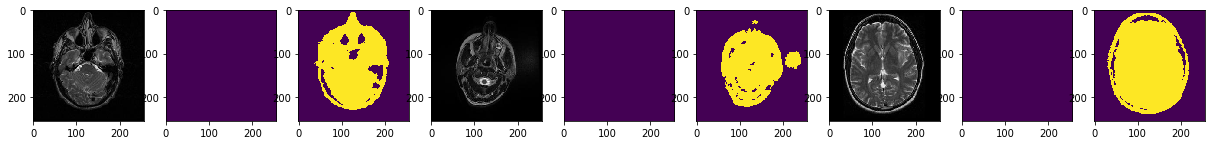

In [7]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Predict on train, val and test
#model = load_model('model.h5', custom_objects={'dice_loss': dice_loss, 'dice_coeff': dice_coeff})

#preds_train = model.predict(X_array[:int(X_array.shape[0]*0.9)], verbose=1)
#preds_val = model.predict(X_array[int(X_test.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
#preds_test_upsampled = []
#for i in range(len(preds_test)):
#    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True))

fig, axs = plt.subplots(1, 9, figsize=(21, 3))
axs[0].imshow(np.squeeze(X_test[0]), cmap=cm.gray)
axs[1].imshow(np.squeeze(Y_test[0]))
axs[2].imshow(np.squeeze(preds_test_t[0]))
axs[3].imshow(np.squeeze(X_test[4]), cmap=cm.gray)
axs[4].imshow(np.squeeze(Y_test[4]))
axs[5].imshow(np.squeeze(preds_test_t[4]))
axs[6].imshow(np.squeeze(X_test[9]), cmap=cm.gray)
axs[7].imshow(np.squeeze(Y_test[9]))
axs[8].imshow(np.squeeze(preds_test_t[9]))

plt.show()
